<u>**Volatility Forecasting**</u>

**We aim to forecast the SX5E volatility:**
- Investment banks as market makers compute the volatility in a risk-neutral environment
- In contrast, investors like hedge funds will use past and present data to perform statistical analysis to predict future volatility
- Therefore, the spread between the market makers’ levels and investors' research will lead to an investment decision

**I. Realised Volatility Forecasting (univariate):**
- We first use the SX5E historical daily closes from 03/01/2014 to 27/05/2022 and compute the log returns and the realised volatility
- We assume that the realised volatility converges to the market implied volatility ([Realised – Implied] spread mean revert)
- GARCH model is first applied to predict the realised volatility and then we conclude on the strengths and weaknesses

**II. Relative Value (multivariate):**
- Spot and realised volatility alone are not sufficient to forecast volatility
- We will discuss several variables to predict the implied volatility such as the Peers, FX Vol, etc.
- Then we will conclude the pros and cons of the results and advise other methods to strengthen the prediction

<u>I. Realised Volatility</u>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
dataSX5E = pd.read_csv('^STOXX50E.csv',index_col=0,parse_dates=True)
dataSX5E.columns = ['SX5E']

In [9]:
def logReturn(df):
    logReturn = np.log(df.pct_change()+1).dropna()
    return logReturn    

In [10]:
def weeklyRealisedVol(df):
    log = logReturn(df)
    realisedVol = np.sqrt((log**2).rolling(5).sum()*252/5).dropna() * 100
    return realisedVol

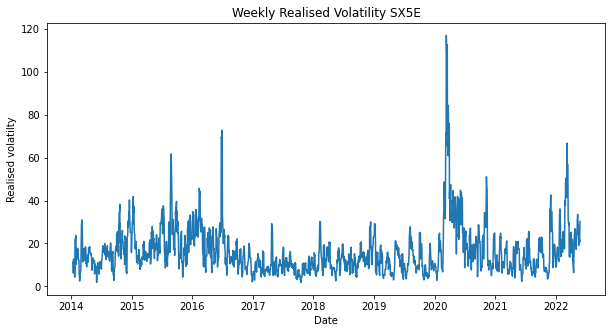

,SX5E
count,2106.000000
mean,16.558770
std,11.421187
min,1.801017
25%,9.308509
50%,13.714398
75%,20.813839
max,117.065643


In [31]:
#Weekly Realised Volatility SX5E

SX5E_weekly_realisedVol = weeklyRealisedVol(dataSX5E)

plt.figure(figsize=(10, 5))
plt.plot(SX5E_weekly_realisedVol.index,SX5E_weekly_realisedVol)
plt.title('Weekly Realised Volatility SX5E')
plt.ylabel('Realised volatilty')
plt.xlabel('Date')
plt.show()

SX5E_weekly_realisedVol.describe()

<u>I.a. Garch Forecasting</u>

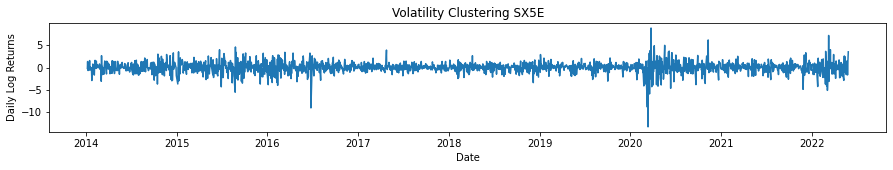

In [30]:
#Volatility Clustering
SX5E_logReturn = logReturn(dataSX5E)

plt.figure(figsize=(15, 2))
plt.plot(SX5E_logReturn.index, SX5E_logReturn*100)
plt.title('Volatility Clustering SX5E')
plt.ylabel('Daily Log Returns')
plt.xlabel('Date')
plt.show()

In [13]:
dailyVol = SX5E_logReturn.std() * 100
monthlyVol = np.sqrt(21) * dailyVol
annualVol = np.sqrt(252) * dailyVol

print('* Daily volatility: ', '{:.2f}%'.format(float(dailyVol.values)))
print('* Monthly volatility: ', '{:.2f}%'.format(float(monthlyVol.values)))
print('* Annual volatility: ', '{:.2f}%'.format(float(annualVol.values)))

* Daily volatility:  1.27%
* Monthly volatility:  5.81%
* Annual volatility:  20.14%


- Standard deviation attributes same weights in the spread between observations and mean over the time series:

$\sigma = \sqrt{\frac{\sum{(x_i-\mu)^2}}{N}}$

- Dynamic models such as GARCH will capture the cluster (Autoregressive and Heteroskedasticity)
    - Assumption: past data influences the current market implied volatility (convergence between Realised Volatility and Implied Volatility), volatility exhibits cluster patterns, autocorrelation, convergence on yhe long term mean
    - GARCH model produces volatility estimates with positive excess kurtosis: fat tail relative to normal distribution, which is in line with empirical observations about returns
    - However, there is the same effect for positive and negative volatility shocks, whereas asset prices tend to respond differently (volatility spikes much faster in market crash than normal market regimes)

In [14]:
from arch import arch_model

def garchForecasting(returns, n):
    rolling_predictions = []
    for i in range(n):
        train_set = returns[:-(n-i)]
        model = arch_model(train_set, p=1, q=1)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1, reindex=False)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
    return rolling_predictions
    

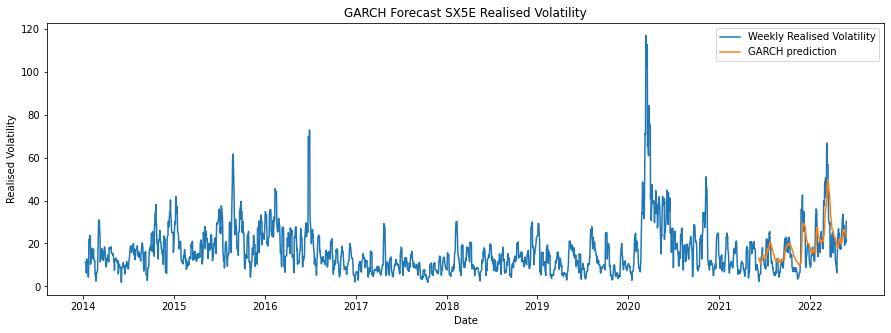

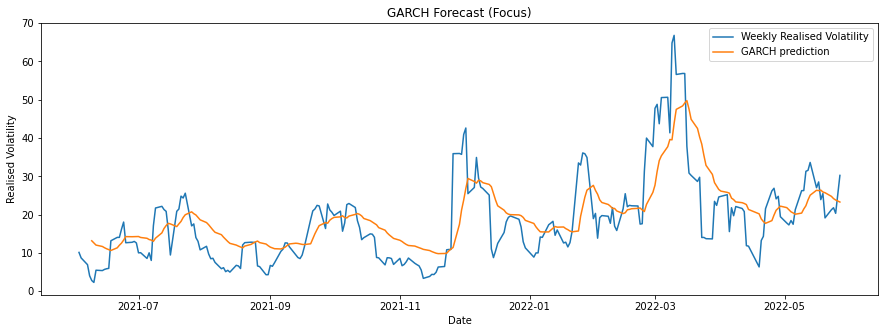

In [32]:
#GARCH(1,1)
returns = SX5E_logReturn * 100
n = 252

predictions = pd.Series(garchForecasting(returns, n), index=returns.index[-n:])
predictionRealised = np.sqrt((predictions**2).rolling(5).sum()*252/5).dropna()

#Plot the results
plt.figure(figsize=(15,5))
plt.plot(SX5E_weekly_realisedVol[:])
plt.plot(predictionRealised)
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.title('GARCH Forecast SX5E Realised Volatility')
plt.legend(['Weekly Realised Volatility', 'GARCH prediction'])
plt.show()

plt.figure(figsize=(15,5))
plt.plot(SX5E_weekly_realisedVol[-n:])
plt.plot(predictionRealised)
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.title('GARCH Forecast (Focus)')
plt.legend(['Weekly Realised Volatility', 'GARCH prediction'])
plt.show()

- It seems that GARCH is unfit for trading purposes:
    - We can see from graphs that the model is not dynamic enough. Although it captures the trend, the forecasting is too smooth
    - Realised volatility does not take into account market sentiments, events, etc...

<u>**II. Relative Value**</u>

- All else being equal, realised volatility provides valuable information about implied volatility. However, indices such as SX5E are very liquid and efficient
- The moves are sensitive to market events. Therefore, forecasting the realised volatility with the past data may not be enough
- In general, when the volatility level is high, the market is pricing events (e.g. Elections, Central Bank News)

**Implied Volatility:**
- First, we will work with the historical implied volatility data and percentiles to see where the current level stands
- Then, we will input other variables for the multiple regression model to predict the future implied volatility
- Market option (call/put) prices should be used for this exercise. For data access reasons, we will use the VSTOXX as a proxy

In [16]:
dataVSTOXX = pd.read_csv('VSTOXX.csv',
                   index_col=0,parse_dates=True)

dataVSTOXX.columns = ['VSTOXX']
dataVSTOXX.sort_index(ascending=True,inplace=True)

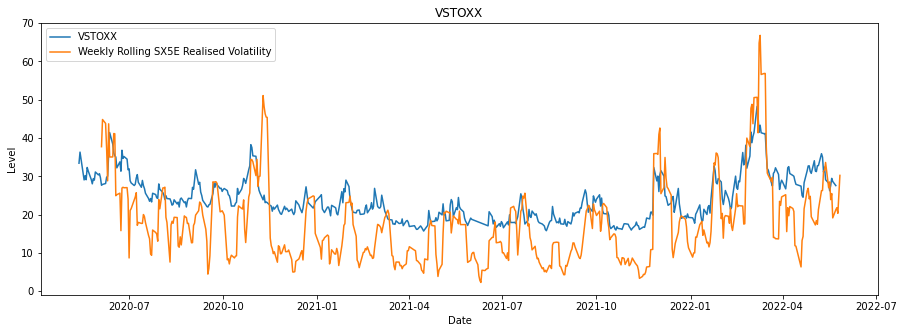

In [33]:
#Plot the VSTOXX

plt.figure(figsize=(15,5))
plt.plot(dataVSTOXX[-252*2:])
plt.plot(SX5E_weekly_realisedVol[-252*2:])
plt.xlabel('Date')
plt.ylabel('Level')
plt.title('VSTOXX')
plt.legend(['VSTOXX', 'Weekly Rolling SX5E Realised Volatility'])
plt.show()

In [34]:
#Percentiles

dataVSTOXX[-252*7:].describe(percentiles=[.15 ,.25, .5, .75, .9, .95])

,VSTOXX
count,1764.000000
mean,20.785561
std,8.153653
min,10.680000
15%,13.680000
25%,14.975000
50%,18.975000
75%,24.110000
90%,30.727000
95%,34.487000


In [19]:
SX5E_weekly_realisedVol[-252*7:].describe(percentiles=[.15 ,.25, .5, .75, .9, .95])

,SX5E
count,1764.000000
mean,16.613366
std,12.076746
min,1.801017
15%,6.968397
25%,8.905140
50%,13.361476
75%,21.015722
90%,29.938495
95%,36.780931


**Factors that could influence the value of volatility other than realised volatility (autocorrelated):**
- Volatility Cone: how often has realised volatility been above the current level of implied?
- Market Performance: in a sell-off is it better to own volatility on underlying which have sold off most, or least?
- Peers: where is the volatility trading relative to how it usually trades vs. sector peers?
- Skew: steep skew indicates risk aversion, is it better to be long or short volatility on step skew names?
- Cross-Asset Risk-On/Risk-Off: FX vol, etc...

**Others (more applicable for single stocks):**
- CDS: should companies with higher CDS spreads trade at higher volatility?
- P/E: should high P/E lead to high volatility or vice-versa?
- Dividend Yields: should a high yield imply lower risk and hence lower volatility?
- Market Capitalisation: should large companies have lower volatility?

<i>Reference: JP Morgan, Relative Value Single Stock Volatility, 2007</i>

**Multiple Regression (Example)**

- We will predict the VSTOXX with multiple linear regression model: Y= Log Return VSTOXX and we take X = Log Return SX5E, AUDUSD, VIX
- Data from 06/01/2014 to 23/06/2022

In [24]:
import numpy as np
from scipy.stats import norm
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [25]:
dataAUDUSD = pd.read_csv('AUDUSD=X.csv',
                   index_col=0,parse_dates=True)

dataAUDUSD.columns = ['AUDUSD']

dataVIX = pd.read_csv('^VIX.csv',
                   index_col=0,parse_dates=True)

dataVIX.columns = ['VIX']

In [35]:
#Clean the data for regression

logReturnSX5E = logReturn(dataSX5E)
logReturnVSTOXX = logReturn(dataVSTOXX)
logReturnAUDUSD = logReturn(dataAUDUSD)
logReturnVIX = logReturn(dataVIX)

globaldf = logReturnSX5E.join(logReturnVSTOXX)
globaldf = globaldf.join(logReturnAUDUSD)
globaldf = globaldf.join(logReturnVIX)

globaldf.dropna(inplace=True)

In [37]:
#Multiple linear regression

Y = globaldf['VSTOXX'].values
X = globaldf.loc[:,['SX5E','AUDUSD','VIX']].values
X = sm.add_constant(X)

ols_fit = sm.OLS(Y,X).fit()
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     1024.
Date:                Sun, 26 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:15:59   Log-Likelihood:                 3317.2
No. Observations:                2042   AIC:                            -6626.
Df Residuals:                    2038   BIC:                            -6604.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.911e-05      0.001      0.094      0.9

<u>Observations</u>:
- High R-squared
- P-Values at 0
- Multicollinearity (average)
    - In practice there is a lag (we predict today Implied Volatility with yesterday’s value)

**Lagged Multiple Regression**
- Here we have shifted the regressors data by 1, so we have our log returns data until 20/05/2022 and we predict the VSTOXX for 23/05/2022
- Proper lag would need to be investigate further

In [38]:
#Lagged multiple regression

Y_lag = globaldf['VSTOXX'][1:].values
X_lag = globaldf.loc[:,['SX5E','AUDUSD','VIX']].shift(1).dropna().values
X_lag = sm.add_constant(X_lag)

ols_fit = sm.OLS(Y_lag,X_lag).fit()
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     65.60
Date:                Sun, 26 Jun 2022   Prob (F-statistic):           1.73e-40
Time:                        17:16:55   Log-Likelihood:                 2471.3
No. Observations:                2041   AIC:                            -4935.
Df Residuals:                    2037   BIC:                            -4912.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.174      0.8

<u>Observation:</u>
- We can see that the R-Squared decreased 
- 28.70 (forecasted) vs 27.58 (market VSTOXX)

<u>Investment Decision:</u>
- We could assume taking an investment decision if there is a spread between our model level and the investment bank’s option price
- We can also investigate the spread level and see where it stands compared to the historical distribution

**Multiple Regression Analysis**
- We can add more regressors as listed in the slide 9. However, the R-squared will mechanically increase (so we can use the adjusted R-squared)
- Adding more regressors can increase multicollinearity. We can check the correlation matrix and drop the highly correlated regressors or assign a ratio to reduce this effect. If there are many correlated regressors, we can extend the exercise to a PCA
- Here, we used a linear model (ordinary least-square). We can open the exercise to other non-linear studies such as random forest